# Similarity Analysis

This notebook loads pre-computed similarity matrices (or computes them if missing) and provides visualization and analysis tools for comparing models across different bottleneck dimensions.

Three similarity metrics are computed:
1. **TN Similarity** - Weight-space similarity using symmetric inner product
2. **Logit Cosine Similarity** - Output-space similarity based on model logits
3. **JS Divergence** - Frequency distribution similarity from eigenvector FFT analysis

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path for imports
# Handle both notebook (no __file__) and script execution
try:
    _this_file = Path(__file__).resolve()
    project_root = _this_file.parent.parent.parent.parent
except NameError:
    # Running in notebook - find project root from cwd or notebook path
    cwd = Path.cwd()
    if (cwd / 'modular_addition').exists():
        project_root = cwd
    else:
        # Try to find it relative to typical notebook locations
        project_root = cwd.parent.parent.parent
        if not (project_root / 'modular_addition').exists():
            project_root = cwd

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from modular_addition.core import (
    load_sweep_results, 
    get_device,
    cosine_similarity_to_metric,
    divergence_to_metric,
    pearson_correlation,
    compute_stress,
    compute_optimal_scale,
    compute_knn_overlap,
    compute_jaccard_index,
    compute_trustworthiness,
    compute_continuity,
    compare_metrics,
    print_comparison_results
)
from modular_addition.compression import (
    load_or_compute_tn_similarity,
    load_or_compute_act_similarity,
    load_or_compute_js_divergence
)

# Configuration
SWEEP_PATH = project_root / 'modular_addition' / 'compression' / 'comp_diagrams' / 'sweep_results_0401.pkl'
DEVICE = get_device()
print(f'Device: {DEVICE}')
print(f'Sweep path: {SWEEP_PATH}')

Device: cpu
Sweep path: /home/martin-lanigo/tn_4_interp/modular_addition/compression/comp_diagrams/sweep_results_0401.pkl


## Load Data and Similarity Matrices

The `load_or_compute_*` functions will load from cache if available, or compute and save to cache.

In [2]:
# Load sweep results
models_state, val_acc, P = load_sweep_results(SWEEP_PATH)
print(f'Loaded {len(models_state)} models with P={P}')

# Load/compute similarity matrices
tn_sim_mat = load_or_compute_tn_similarity(SWEEP_PATH, device=DEVICE)
act_sim_mat = load_or_compute_act_similarity(SWEEP_PATH, device=DEVICE)
js_div_mat = load_or_compute_js_divergence(SWEEP_PATH, device=DEVICE)

print(f'\nMatrix shapes:')
print(f'  TN similarity: {tn_sim_mat.shape}')
print(f'  Activation similarity: {act_sim_mat.shape}')
print(f'  JS divergence: {js_div_mat.shape}')

Loaded 64 models with P=64
Computing TN similarity matrix...


Loading models:   0%|          | 0/64 [00:00<?, ?it/s]

Loading models: 100%|██████████| 64/64 [00:00<00:00, 2749.63it/s]

Computing TN similarity:   0%|          | 0/64 [00:00<?, ?it/s]

Computing TN similarity:   2%|▏         | 1/64 [00:01<01:35,  1.51s/it]

Computing TN similarity:   5%|▍         | 3/64 [00:01<00:28,  2.16it/s]

Computing TN similarity:   6%|▋         | 4/64 [00:01<00:21,  2.75it/s]

Computing TN similarity:   9%|▉         | 6/64 [00:02<00:12,  4.56it/s]

Computing TN similarity:  12%|█▎        | 8/64 [00:02<00:08,  6.44it/s]

Computing TN similarity:  16%|█▌        | 10/64 [00:02<00:06,  8.29it/s]

Computing TN similarity:  19%|█▉        | 12/64 [00:02<00:05, 10.15it/s]

Computing TN similarity:  22%|██▏       | 14/64 [00:02<00:04, 11.99it/s]

Computing TN similarity:  25%|██▌       | 16/64 [00:02<00:03, 13.72it/s]

Computing TN similarity:  28%|██▊       | 18/64 [00:02<00:03, 14.99it/s]

Computing TN similarity:  33%|███▎      | 21/64 [00:02<00:02, 15.84it/s]

Computing TN similarity:  36%|███▌      | 23/64 [00:02<00:02, 16.35it/s]

Computing TN similarity:  41%|████      | 26/64 [00:03<00:02, 17.73it/s]

Computing TN similarity:  45%|████▌     | 29/64 [00:03<00:01, 19.81it/s]

Computing TN similarity:  52%|█████▏    | 33/64 [00:03<00:01, 22.94it/s]

Computing TN similarity:  56%|█████▋    | 36/64 [00:03<00:01, 24.53it/s]

Computing TN similarity:  62%|██████▎   | 40/64 [00:03<00:00, 27.25it/s]

Computing TN similarity:  69%|██████▉   | 44/64 [00:03<00:00, 28.91it/s]

Computing TN similarity:  77%|███████▋  | 49/64 [00:03<00:00, 33.58it/s]

Computing TN similarity:  88%|████████▊ | 56/64 [00:03<00:00, 43.15it/s]

Computing TN similarity: 100%|██████████| 64/64 [00:03<00:00, 16.07it/s]

Saved TN similarity to cache: /home/martin-lanigo/tn_4_interp/modular_addition/compression/comp_diagrams/tn_similarity_matrix.npy
Computing activation similarity matrix...


Computing logits:   0%|          | 0/64 [00:00<?, ?it/s]

Computing logits: 100%|██████████| 64/64 [00:00<00:00, 703.36it/s]

Computing logit similarity:   0%|          | 0/64 [00:00<?, ?it/s]

Computing logit similarity:   6%|▋         | 4/64 [00:00<00:01, 34.39it/s]

Computing logit similarity:  12%|█▎        | 8/64 [00:00<00:01, 33.29it/s]

Computing logit similarity:  19%|█▉        | 12/64 [00:00<00:01, 33.02it/s]

Computing logit similarity:  25%|██▌       | 16/64 [00:00<00:01, 33.39it/s]

Computing logit similarity:  33%|███▎      | 21/64 [00:00<00:01, 37.38it/s]

Computing logit similarity:  41%|████      | 26/64 [00:00<00:00, 40.14it/s]

Computing logit similarity:  50%|█████     | 32/64 [00:00<00:00, 44.91it/s]

Computing logit similarity:  61%|██████    | 39/64 [00:00<00:00, 52.21it/s]

Computing logit similarity:  77%|███████▋  | 49/64 [00:01<00:00, 66.29it/s]

Computing logit similarity: 100%|██████████| 64/64 [00:01<00:00, 59.71it/s]

Saved activation similarity to cache: /home/martin-lanigo/tn_4_interp/modular_addition/compression/comp_diagrams/act_similarity_matrix.npy
Computing JS divergence matrix...


Computing interaction matrices:   0%|          | 0/64 [00:00<?, ?it/s]

Computing interaction matrices:  23%|██▎       | 15/64 [00:00<00:00, 145.65it/s]

Computing interaction matrices:  48%|████▊     | 31/64 [00:00<00:00, 152.73it/s]

Computing interaction matrices:  73%|███████▎  | 47/64 [00:00<00:00, 152.69it/s]

Computing interaction matrices: 100%|██████████| 64/64 [00:00<00:00, 157.88it/s]

Computing eigendecomposition:   0%|          | 0/64 [00:00<?, ?it/s]

Computing eigendecomposition:   2%|▏         | 1/64 [00:00<00:26,  2.36it/s]

Computing eigendecomposition:   3%|▎         | 2/64 [00:00<00:23,  2.62it/s]

Computing eigendecomposition:   5%|▍         | 3/64 [00:01<00:23,  2.63it/s]

Computing eigendecomposition:   6%|▋         | 4/64 [00:01<00:20,  2.89it/s]

Computing eigendecomposition:   8%|▊         | 5/64 [00:01<00:18,  3.13it/s]

Computing eigendecomposition:   9%|▉         | 6/64 [00:02<00:19,  2.93it/s]

Computing eigendecomposition:  11%|█         | 7/64 [00:02<00:18,  3.05it/s]

Computing eigendecomposition:  12%|█▎        | 8/64 [00:02<00:18,  3.10it/s]

Computing eigendecomposition:  14%|█▍        | 9/64 [00:03<00:17,  3.10it/s]

Computing eigendecomposition:  16%|█▌        | 10/64 [00:03<00:17,  3.09it/s]

Computing eigendecomposition:  17%|█▋        | 11/64 [00:03<00:16,  3.17it/s]

Computing eigendecomposition:  19%|█▉        | 12/64 [00:04<00:17,  3.05it/s]

Computing eigendecomposition:  20%|██        | 13/64 [00:04<00:15,  3.29it/s]

Computing eigendecomposition:  22%|██▏       | 14/64 [00:04<00:14,  3.44it/s]

Computing eigendecomposition:  23%|██▎       | 15/64 [00:04<00:14,  3.40it/s]

Computing eigendecomposition:  25%|██▌       | 16/64 [00:05<00:16,  2.95it/s]

Computing eigendecomposition:  27%|██▋       | 17/64 [00:05<00:16,  2.94it/s]

Computing eigendecomposition:  28%|██▊       | 18/64 [00:05<00:14,  3.07it/s]

Computing eigendecomposition:  30%|██▉       | 19/64 [00:06<00:14,  3.21it/s]

Computing eigendecomposition:  31%|███▏      | 20/64 [00:06<00:12,  3.48it/s]

Computing eigendecomposition:  33%|███▎      | 21/64 [00:06<00:14,  2.90it/s]

Computing eigendecomposition:  34%|███▍      | 22/64 [00:07<00:16,  2.54it/s]

Computing eigendecomposition:  36%|███▌      | 23/64 [00:07<00:18,  2.26it/s]

Computing eigendecomposition:  38%|███▊      | 24/64 [00:08<00:23,  1.74it/s]

Computing eigendecomposition:  39%|███▉      | 25/64 [00:09<00:21,  1.78it/s]

Computing eigendecomposition:  41%|████      | 26/64 [00:09<00:19,  1.95it/s]

Computing eigendecomposition:  42%|████▏     | 27/64 [00:10<00:19,  1.93it/s]

Computing eigendecomposition:  44%|████▍     | 28/64 [00:10<00:19,  1.87it/s]

Computing eigendecomposition:  45%|████▌     | 29/64 [00:11<00:17,  1.97it/s]

Computing eigendecomposition:  47%|████▋     | 30/64 [00:11<00:16,  2.03it/s]

Computing eigendecomposition:  48%|████▊     | 31/64 [00:12<00:16,  1.97it/s]

Computing eigendecomposition:  50%|█████     | 32/64 [00:12<00:16,  1.99it/s]

Computing eigendecomposition:  52%|█████▏    | 33/64 [00:13<00:14,  2.08it/s]

Computing eigendecomposition:  53%|█████▎    | 34/64 [00:13<00:15,  1.99it/s]

Computing eigendecomposition:  55%|█████▍    | 35/64 [00:14<00:15,  1.87it/s]

Computing eigendecomposition:  56%|█████▋    | 36/64 [00:14<00:15,  1.85it/s]

Computing eigendecomposition:  58%|█████▊    | 37/64 [00:15<00:15,  1.69it/s]

Computing eigendecomposition:  59%|█████▉    | 38/64 [00:16<00:14,  1.80it/s]

Computing eigendecomposition:  61%|██████    | 39/64 [00:16<00:13,  1.79it/s]

Computing eigendecomposition:  62%|██████▎   | 40/64 [00:17<00:13,  1.79it/s]

Computing eigendecomposition:  64%|██████▍   | 41/64 [00:17<00:12,  1.81it/s]

Computing eigendecomposition:  66%|██████▌   | 42/64 [00:18<00:11,  1.93it/s]

Computing eigendecomposition:  67%|██████▋   | 43/64 [00:18<00:10,  2.07it/s]

Computing eigendecomposition:  69%|██████▉   | 44/64 [00:19<00:11,  1.78it/s]

Computing eigendecomposition:  70%|███████   | 45/64 [00:20<00:11,  1.66it/s]

Computing eigendecomposition:  72%|███████▏  | 46/64 [00:20<00:10,  1.70it/s]

Computing eigendecomposition:  73%|███████▎  | 47/64 [00:21<00:09,  1.77it/s]

Computing eigendecomposition:  75%|███████▌  | 48/64 [00:21<00:08,  1.87it/s]

Computing eigendecomposition:  77%|███████▋  | 49/64 [00:22<00:07,  1.91it/s]

Computing eigendecomposition:  78%|███████▊  | 50/64 [00:22<00:07,  1.89it/s]

Computing eigendecomposition:  80%|███████▉  | 51/64 [00:23<00:06,  1.92it/s]

Computing eigendecomposition:  81%|████████▏ | 52/64 [00:23<00:06,  1.86it/s]

Computing eigendecomposition:  83%|████████▎ | 53/64 [00:24<00:05,  1.95it/s]

Computing eigendecomposition:  84%|████████▍ | 54/64 [00:24<00:04,  2.01it/s]

Computing eigendecomposition:  86%|████████▌ | 55/64 [00:25<00:04,  2.04it/s]

Computing eigendecomposition:  88%|████████▊ | 56/64 [00:25<00:04,  1.97it/s]

Computing eigendecomposition:  89%|████████▉ | 57/64 [00:26<00:03,  2.06it/s]

Computing eigendecomposition:  91%|█████████ | 58/64 [00:26<00:02,  2.09it/s]

Computing eigendecomposition:  92%|█████████▏| 59/64 [00:27<00:02,  1.91it/s]

Computing eigendecomposition:  94%|█████████▍| 60/64 [00:27<00:02,  1.80it/s]

Computing eigendecomposition:  95%|█████████▌| 61/64 [00:28<00:01,  1.79it/s]

Computing eigendecomposition:  97%|█████████▋| 62/64 [00:28<00:01,  1.93it/s]

Computing eigendecomposition:  98%|█████████▊| 63/64 [00:29<00:00,  1.75it/s]

Computing eigendecomposition: 100%|██████████| 64/64 [00:30<00:00,  1.73it/s]

Computing eigendecomposition: 100%|██████████| 64/64 [00:30<00:00,  2.13it/s]

Computing frequency heatmaps:   0%|          | 0/64 [00:00<?, ?it/s]

Computing frequency heatmaps:  12%|█▎        | 8/64 [00:00<00:00, 70.07it/s]

Computing frequency heatmaps:  36%|███▌      | 23/64 [00:00<00:00, 113.16it/s]

Computing frequency heatmaps:  66%|██████▌   | 42/64 [00:00<00:00, 143.29it/s]

Computing frequency heatmaps:  89%|████████▉ | 57/64 [00:00<00:00, 143.59it/s]

Computing frequency heatmaps: 100%|██████████| 64/64 [00:00<00:00, 138.06it/s]

Computing JS divergence:   0%|          | 0/64 [00:00<?, ?it/s]

Computing JS divergence:   2%|▏         | 1/64 [00:00<00:08,  7.38it/s]

Computing JS divergence:   3%|▎         | 2/64 [00:00<00:08,  7.59it/s]

Computing JS divergence:   5%|▍         | 3/64 [00:00<00:07,  7.90it/s]

Computing JS divergence:   6%|▋         | 4/64 [00:00<00:07,  8.09it/s]

Computing JS divergence:   8%|▊         | 5/64 [00:00<00:07,  7.69it/s]

Computing JS divergence:   9%|▉         | 6/64 [00:00<00:07,  8.13it/s]

Computing JS divergence:  12%|█▎        | 8/64 [00:00<00:06,  8.69it/s]

Computing JS divergence:  14%|█▍        | 9/64 [00:01<00:06,  8.54it/s]

Computing JS divergence:  17%|█▋        | 11/64 [00:01<00:05,  9.20it/s]

Computing JS divergence:  20%|██        | 13/64 [00:01<00:05,  9.41it/s]

Computing JS divergence:  23%|██▎       | 15/64 [00:01<00:04,  9.85it/s]

Computing JS divergence:  27%|██▋       | 17/64 [00:01<00:04, 10.26it/s]

Computing JS divergence:  30%|██▉       | 19/64 [00:02<00:04, 10.67it/s]

Computing JS divergence:  33%|███▎      | 21/64 [00:02<00:03, 11.09it/s]

Computing JS divergence:  36%|███▌      | 23/64 [00:02<00:03, 11.53it/s]

Computing JS divergence:  39%|███▉      | 25/64 [00:02<00:03, 11.98it/s]

Computing JS divergence:  42%|████▏     | 27/64 [00:02<00:02, 12.78it/s]

Computing JS divergence:  45%|████▌     | 29/64 [00:02<00:02, 13.41it/s]

Computing JS divergence:  48%|████▊     | 31/64 [00:02<00:02, 13.60it/s]

Computing JS divergence:  52%|█████▏    | 33/64 [00:03<00:02, 14.01it/s]

Computing JS divergence:  55%|█████▍    | 35/64 [00:03<00:02, 14.47it/s]

Computing JS divergence:  58%|█████▊    | 37/64 [00:03<00:01, 15.14it/s]

Computing JS divergence:  61%|██████    | 39/64 [00:03<00:01, 16.13it/s]

Computing JS divergence:  64%|██████▍   | 41/64 [00:03<00:01, 16.94it/s]

Computing JS divergence:  69%|██████▉   | 44/64 [00:03<00:01, 18.48it/s]

Computing JS divergence:  73%|███████▎  | 47/64 [00:03<00:00, 20.03it/s]

Computing JS divergence:  78%|███████▊  | 50/64 [00:03<00:00, 22.12it/s]

Computing JS divergence:  84%|████████▍ | 54/64 [00:03<00:00, 26.03it/s]

Computing JS divergence:  97%|█████████▋| 62/64 [00:04<00:00, 39.92it/s]

Computing JS divergence: 100%|██████████| 64/64 [00:04<00:00, 15.63it/s]

Saved JS divergence to cache: /home/martin-lanigo/tn_4_interp/modular_addition/compression/comp_diagrams/js_divergence_matrix.npy

Matrix shapes:
  TN similarity: (64, 64)
  Activation similarity: (64, 64)
  JS divergence: (64, 64)


## Validation Accuracy Curve

Reference plot showing model performance across bottleneck dimensions.

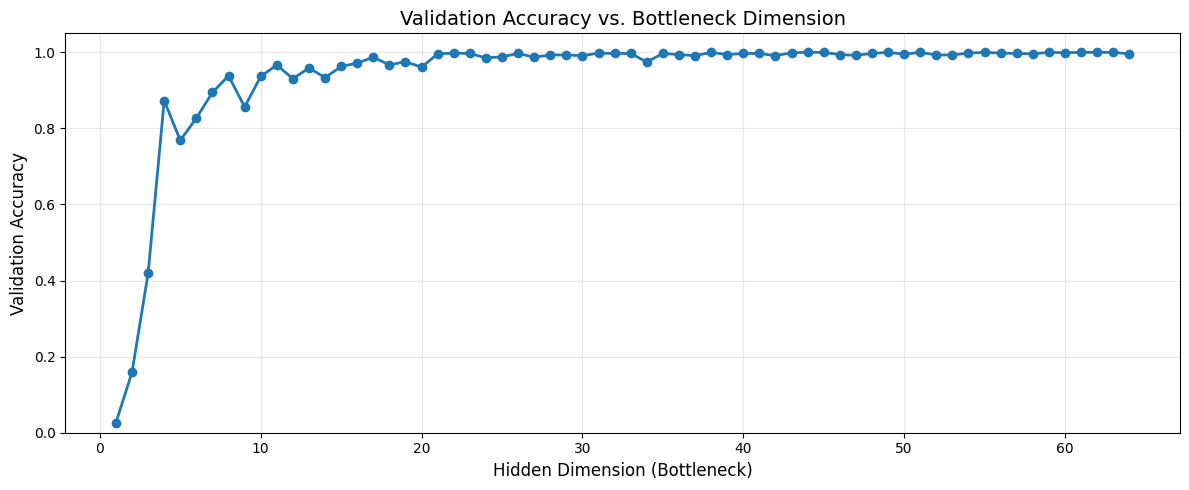

In [3]:
if len(val_acc) > 0:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6)
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
else:
    print('No validation accuracies available.')

## Side-by-Side Similarity Heatmaps

Compare all three similarity metrics at once.

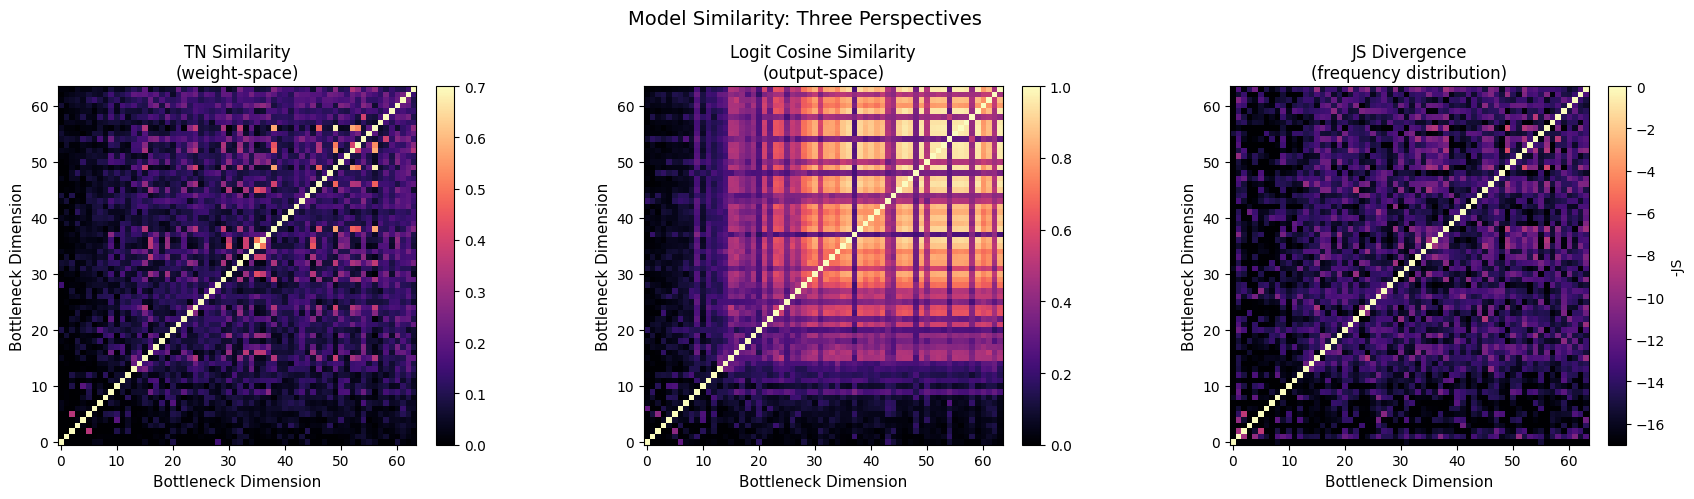

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# TN Similarity
ax1 = axes[0]
im1 = ax1.imshow(tn_sim_mat, cmap='magma', vmin=0, vmax=0.7, origin='lower')
ax1.set_xlabel('Bottleneck Dimension', fontsize=11)
ax1.set_ylabel('Bottleneck Dimension', fontsize=11)
ax1.set_title('TN Similarity\n(weight-space)', fontsize=12)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Logit Cosine Similarity
ax2 = axes[1]
im2 = ax2.imshow(act_sim_mat, cmap='magma', vmin=0, vmax=1.0, origin='lower')
ax2.set_xlabel('Bottleneck Dimension', fontsize=11)
ax2.set_ylabel('Bottleneck Dimension', fontsize=11)
ax2.set_title('Logit Cosine Similarity\n(output-space)', fontsize=12)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

# JS Divergence (negated for visual consistency - lower divergence = more similar)
ax3 = axes[2]
im3 = ax3.imshow(-js_div_mat, cmap='magma', origin='lower', vmin=-17)
ax3.set_xlabel('Bottleneck Dimension', fontsize=11)
ax3.set_ylabel('Bottleneck Dimension', fontsize=11)
ax3.set_title('JS Divergence\n(frequency distribution)', fontsize=12)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='-JS')

plt.suptitle('Model Similarity: Three Perspectives', fontsize=14)
plt.tight_layout()
plt.show()

## Individual Heatmap Exploration

Interactive exploration with adjustable color scales.

In [5]:
def plot_similarity_heatmap(metric='TN', vmin=0.0, vmax=1.0):
    """Plot a single similarity heatmap with adjustable parameters."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if metric == 'TN':
        data = tn_sim_mat
        title = 'TN Similarity (weight-space)'
    elif metric == 'Logit':
        data = act_sim_mat
        title = 'Logit Cosine Similarity (output-space)'
    else:  # JS
        data = -js_div_mat  # Negate for visual consistency
        title = 'Negative JS Divergence (frequency)'
    
    im = ax.imshow(data, cmap='magma', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_xlabel('Bottleneck Dimension', fontsize=12)
    ax.set_ylabel('Bottleneck Dimension', fontsize=12)
    ax.set_title(title, fontsize=14)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Create interactive widgets
metric_dropdown = widgets.Dropdown(
    options=['TN', 'Logit', 'JS'],
    value='TN',
    description='Metric:'
)
vmin_slider = widgets.FloatSlider(min=-20, max=1, step=0.1, value=0.0, description='vmin')
vmax_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=1.0, description='vmax')

out = widgets.interactive_output(
    plot_similarity_heatmap,
    {'metric': metric_dropdown, 'vmin': vmin_slider, 'vmax': vmax_slider}
)
display(widgets.VBox([widgets.HBox([metric_dropdown, vmin_slider, vmax_slider]), out]))

## Correlation Analysis Between Metrics

How do the different similarity metrics relate to each other?

In [6]:
# Flatten upper triangular parts for correlation (exclude diagonal)
upper_idx = np.triu_indices(P, k=1)

tn_flat = tn_sim_mat[upper_idx]
act_flat = act_sim_mat[upper_idx]
js_flat = js_div_mat[upper_idx]

# Compute correlations
corr_tn_act = np.corrcoef(tn_flat, act_flat)[0, 1]
corr_tn_js = np.corrcoef(tn_flat, -js_flat)[0, 1]  # Negate JS for positive correlation
corr_act_js = np.corrcoef(act_flat, -js_flat)[0, 1]

print('Pairwise Correlations (upper triangular, excluding diagonal):')
print(f'  TN vs Logit: {corr_tn_act:.4f}')
print(f'  TN vs -JS:   {corr_tn_js:.4f}')
print(f'  Logit vs -JS: {corr_act_js:.4f}')

Pairwise Correlations (upper triangular, excluding diagonal):
  TN vs Logit: 0.5523
  TN vs -JS:   0.6196
  Logit vs -JS: 0.4427


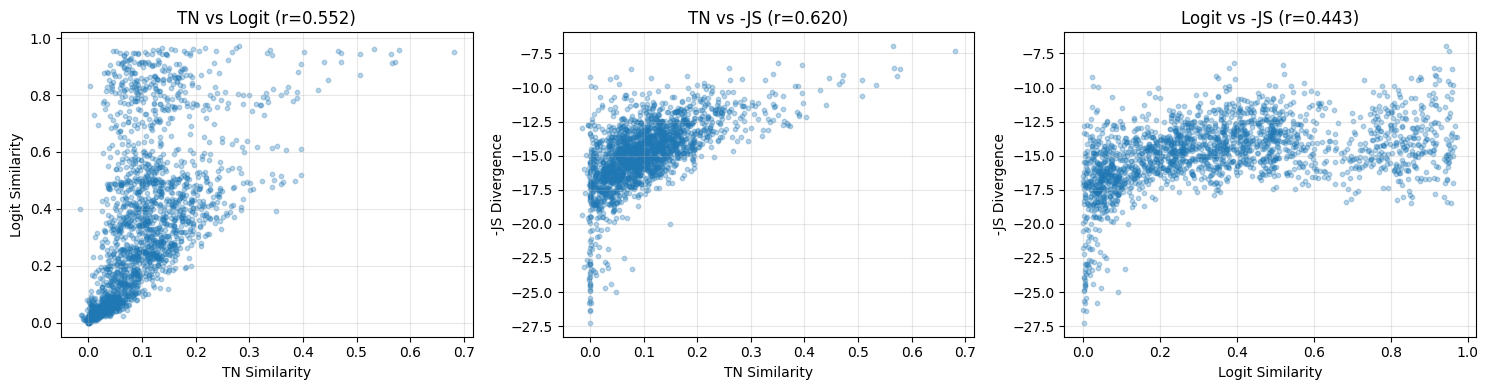

In [7]:
# Scatter plots of metric relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
ax1.scatter(tn_flat, act_flat, alpha=0.3, s=10)
ax1.set_xlabel('TN Similarity')
ax1.set_ylabel('Logit Similarity')
ax1.set_title(f'TN vs Logit (r={corr_tn_act:.3f})')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.scatter(tn_flat, -js_flat, alpha=0.3, s=10)
ax2.set_xlabel('TN Similarity')
ax2.set_ylabel('-JS Divergence')
ax2.set_title(f'TN vs -JS (r={corr_tn_js:.3f})')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.scatter(act_flat, -js_flat, alpha=0.3, s=10)
ax3.set_xlabel('Logit Similarity')
ax3.set_ylabel('-JS Divergence')
ax3.set_title(f'Logit vs -JS (r={corr_act_js:.3f})')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Similarity Profile by Bottleneck Dimension

How similar is each model to all others? Compare similarity profiles.

In [8]:
def plot_similarity_profile(dim_idx=P-1):
    """Plot similarity profile for a given bottleneck dimension."""
    d = dim_idx + 1  # Convert to 1-indexed dimension
    dims = np.arange(1, P+1)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(dims, tn_sim_mat[dim_idx], 'o-', label='TN', markersize=4)
    ax.plot(dims, act_sim_mat[dim_idx], 's-', label='Logit', markersize=4)
    ax.plot(dims, -js_div_mat[dim_idx] / 17, '^-', label='-JS/17', markersize=4)  # Scaled
    
    ax.axvline(d, color='red', linestyle='--', alpha=0.5, label=f'd={d}')
    ax.set_xlabel('Comparison Bottleneck Dimension')
    ax.set_ylabel('Similarity')
    ax.set_title(f'Similarity Profile for d_hidden={d}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

dim_slider = widgets.IntSlider(min=0, max=P-1, step=1, value=P-1, description='dim_idx')
out = widgets.interactive_output(plot_similarity_profile, {'dim_idx': dim_slider})
display(dim_slider, out)

IntSlider(value=63, description='dim_idx', max=63)

Output()

## Summary Statistics

In [9]:
print('Summary Statistics (excluding diagonal):')
print('\nTN Similarity:')
print(f'  Mean: {tn_flat.mean():.4f}')
print(f'  Std:  {tn_flat.std():.4f}')
print(f'  Range: [{tn_flat.min():.4f}, {tn_flat.max():.4f}]')

print('\nLogit Cosine Similarity:')
print(f'  Mean: {act_flat.mean():.4f}')
print(f'  Std:  {act_flat.std():.4f}')
print(f'  Range: [{act_flat.min():.4f}, {act_flat.max():.4f}]')

print('\nJS Divergence:')
print(f'  Mean: {js_flat.mean():.4f}')
print(f'  Std:  {js_flat.std():.4f}')
print(f'  Range: [{js_flat.min():.4f}, {js_flat.max():.4f}]')

Summary Statistics (excluding diagonal):

TN Similarity:
  Mean: 0.1031
  Std:  0.0805
  Range: [-0.0159, 0.6815]

Logit Cosine Similarity:
  Mean: 0.3566
  Std:  0.2705
  Range: [-0.0009, 0.9721]

JS Divergence:
  Mean: 14.8710
  Std:  2.4648
  Range: [6.9629, 27.2628]


---

# Metric Comparison Analysis

Convert similarities to proper distance metrics and compare them using:
1. **Pearson correlation** - Global linear relationship
2. **Procrustes stress** - Scale-invariant distortion measure
3. **Neighborhood preservation** - Local structure agreement (k-NN overlap, Jaccard, Trustworthiness)

## Convert Similarities to Distance Metrics

For inner product-based similarities:
$$d(A,B)^2 = \|A\|^2 + \|B\|^2 - 2\langle A | B \rangle$$

For cosine similarity (normalized vectors):
$$d^2 = 2(1 - \cos\theta)$$

For JS divergence, $\sqrt{\text{JS}}$ is a proper metric.

In [10]:
# Convert to distance metrics
D_tn = cosine_similarity_to_metric(tn_sim_mat)
D_act = cosine_similarity_to_metric(act_sim_mat)
D_js = divergence_to_metric(js_div_mat)

print('Distance matrices computed:')
print(f'  D_tn:  range [{D_tn.min():.4f}, {D_tn.max():.4f}]')
print(f'  D_act: range [{D_act.min():.4f}, {D_act.max():.4f}]')
print(f'  D_js:  range [{D_js.min():.4f}, {D_js.max():.4f}]')

Distance matrices computed:
  D_tn:  range [0.0000, 1.4254]
  D_act: range [0.0000, 1.4149]
  D_js:  range [0.0000, 5.2214]


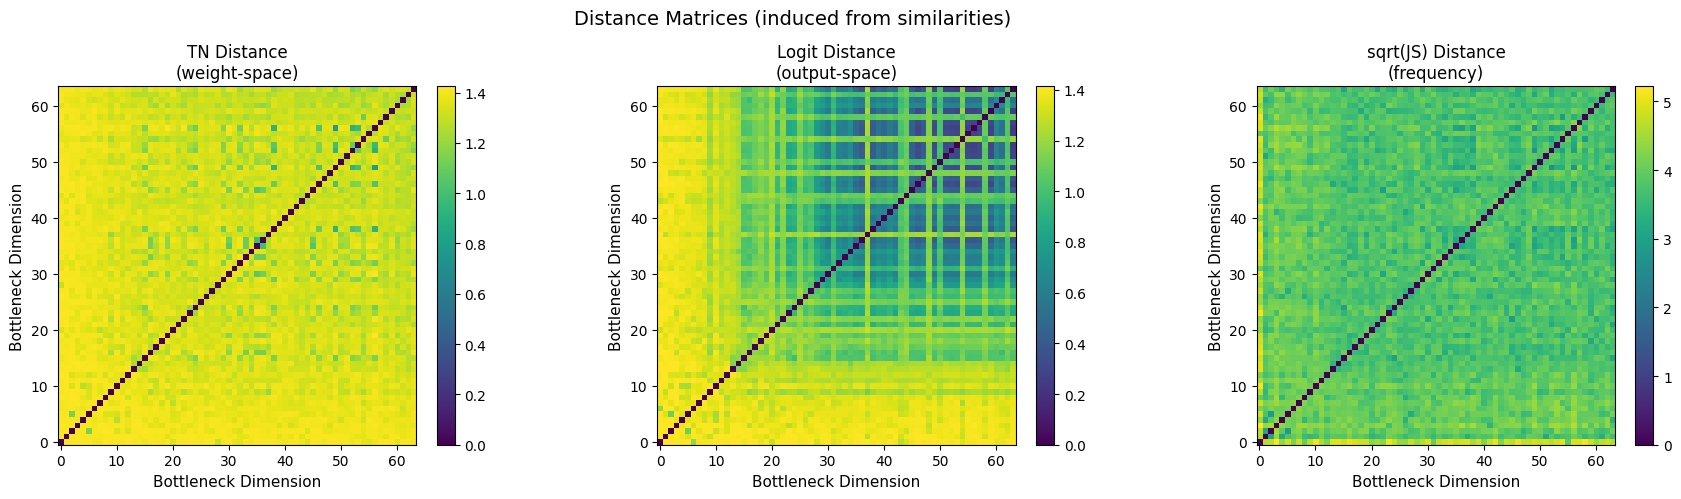

In [11]:
# Visualize distance matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
im1 = ax1.imshow(D_tn, cmap='viridis', origin='lower')
ax1.set_xlabel('Bottleneck Dimension', fontsize=11)
ax1.set_ylabel('Bottleneck Dimension', fontsize=11)
ax1.set_title('TN Distance\n(weight-space)', fontsize=12)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

ax2 = axes[1]
im2 = ax2.imshow(D_act, cmap='viridis', origin='lower')
ax2.set_xlabel('Bottleneck Dimension', fontsize=11)
ax2.set_ylabel('Bottleneck Dimension', fontsize=11)
ax2.set_title('Logit Distance\n(output-space)', fontsize=12)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

ax3 = axes[2]
im3 = ax3.imshow(D_js, cmap='viridis', origin='lower')
ax3.set_xlabel('Bottleneck Dimension', fontsize=11)
ax3.set_ylabel('Bottleneck Dimension', fontsize=11)
ax3.set_title('sqrt(JS) Distance\n(frequency)', fontsize=12)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.suptitle('Distance Matrices (induced from similarities)', fontsize=14)
plt.tight_layout()
plt.show()

## Global Comparison: Correlation and Stress

**Procrustes Stress** measures how well one distance matrix approximates another:
$$\text{stress}(D, D') = \sqrt{\frac{\sum_{i<j}(D_{ij} - \alpha D'_{ij})^2}{\sum_{i<j} D_{ij}^2}}$$

where $\alpha$ is the optimal scaling factor.

In [12]:
# Compute all pairwise comparisons
metrics = {'TN': D_tn, 'Logit': D_act, 'JS': D_js}
metric_names = list(metrics.keys())

print('Global Metric Comparison')
print('=' * 60)

print('\nPearson Correlation (distance matrices):')
for i, name1 in enumerate(metric_names):
    for name2 in metric_names[i+1:]:
        corr = pearson_correlation(metrics[name1], metrics[name2])
        print(f'  {name1} vs {name2}: {corr:.4f}')

print('\nProcrustes Stress (D1 approximated by scaled D2):')
for i, name1 in enumerate(metric_names):
    for name2 in metric_names[i+1:]:
        stress = compute_stress(metrics[name1], metrics[name2])
        alpha = compute_optimal_scale(metrics[name1], metrics[name2])
        print(f'  {name1} vs {name2}: stress={stress:.4f}, optimal_scale={alpha:.4f}')

Global Metric Comparison

Pearson Correlation (distance matrices):
  TN vs Logit: 0.5089
  TN vs JS: 0.6293
  Logit vs JS: 0.3973

Procrustes Stress (D1 approximated by scaled D2):
  TN vs Logit: stress=0.2304, optimal_scale=1.1490
  TN vs JS: stress=0.0634, optimal_scale=0.3466
  Logit vs JS: stress=0.2306, optimal_scale=0.2862


## Neighborhood Preservation Analysis

For "similar models should be close," local structure matters more than global correlation.

**k-NN Overlap**: Average fraction of shared neighbors
$$\text{overlap} = \frac{1}{N} \sum_i \frac{|\text{NN}_k^{D_1}(i) \cap \text{NN}_k^{D_2}(i)|}{k}$$

**Jaccard Index**: $\frac{|A \cap B|}{|A \cup B|}$

**Trustworthiness**: Penalizes false neighbors (close in D2 but far in D1)

**Continuity**: Penalizes missing neighbors (close in D1 but far in D2)

In [13]:
# Compute neighborhood preservation for various k values
k_values = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50]

# Store results for plotting
results = {}
pairs = [('TN', 'Logit'), ('TN', 'JS'), ('Logit', 'JS')]

for name1, name2 in pairs:
    D1, D2 = metrics[name1], metrics[name2]
    results[(name1, name2)] = {
        'knn_overlap': [compute_knn_overlap(D1, D2, k) for k in k_values],
        'jaccard': [compute_jaccard_index(D1, D2, k) for k in k_values],
        'trustworthiness': [compute_trustworthiness(D1, D2, k) for k in k_values],
        'continuity': [compute_continuity(D1, D2, k) for k in k_values],
    }

print('Neighborhood preservation analysis computed for k =', k_values)

Neighborhood preservation analysis computed for k = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50]


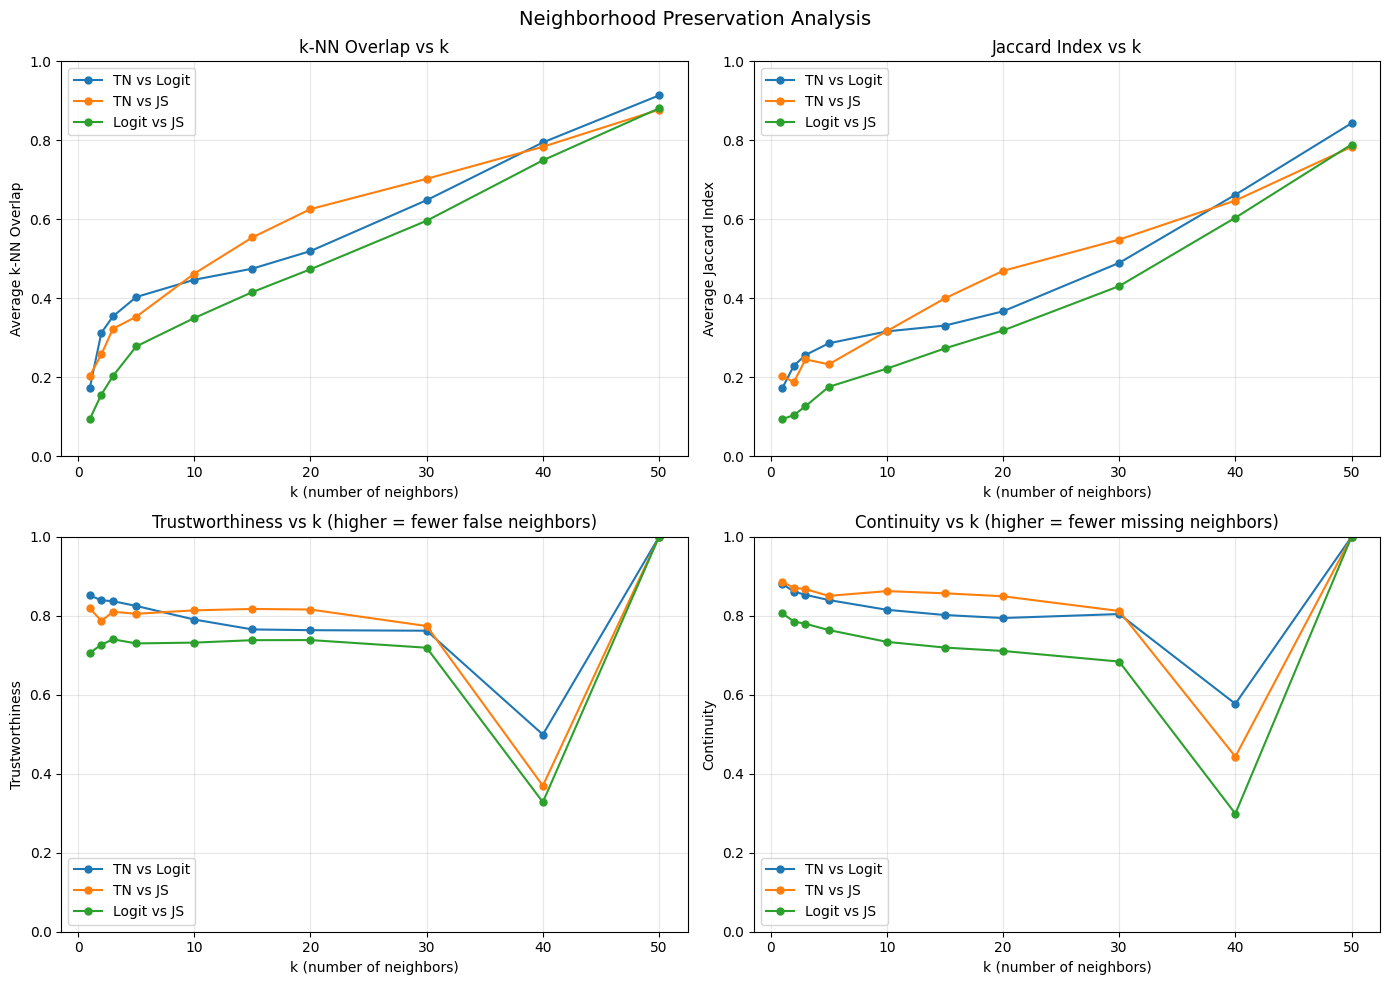

In [14]:
# Plot k-NN overlap curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# k-NN Overlap
ax = axes[0, 0]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['knn_overlap'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Average k-NN Overlap')
ax.set_title('k-NN Overlap vs k')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Jaccard Index
ax = axes[0, 1]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['jaccard'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Average Jaccard Index')
ax.set_title('Jaccard Index vs k')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Trustworthiness
ax = axes[1, 0]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['trustworthiness'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Trustworthiness')
ax.set_title('Trustworthiness vs k (higher = fewer false neighbors)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Continuity
ax = axes[1, 1]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['continuity'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Continuity')
ax.set_title('Continuity vs k (higher = fewer missing neighbors)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.suptitle('Neighborhood Preservation Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## Comprehensive Comparison Summary

In [15]:
# Print detailed comparison for each pair
for name1, name2 in pairs:
    res = compare_metrics(metrics[name1], metrics[name2], name1, name2, k_values)
    print_comparison_results(res)


Metric Comparison: TN vs Logit

Global Measures:
  Pearson correlation: 0.5089
  Procrustes stress:   0.2304
  Optimal scale α:     1.1490

Neighborhood Preservation (k-NN overlap):
  k= 1: 0.1719
  k= 2: 0.3125
  k= 3: 0.3542
  k= 5: 0.4031
  k=10: 0.4469
  k=15: 0.4750
  k=20: 0.5195
  k=30: 0.6484
  k=40: 0.7945
  k=50: 0.9138

Jaccard Index:
  k= 1: 0.1719
  k= 2: 0.2292
  k= 3: 0.2563
  k= 5: 0.2859
  k=10: 0.3161
  k=15: 0.3308
  k=20: 0.3669
  k=30: 0.4896
  k=40: 0.6621
  k=50: 0.8433

Metric Comparison: TN vs JS

Global Measures:
  Pearson correlation: 0.6293
  Procrustes stress:   0.0634
  Optimal scale α:     0.3466

Neighborhood Preservation (k-NN overlap):
  k= 1: 0.2031
  k= 2: 0.2578
  k= 3: 0.3229
  k= 5: 0.3531
  k=10: 0.4625
  k=15: 0.5542
  k=20: 0.6258
  k=30: 0.7026
  k=40: 0.7836
  k=50: 0.8775

Jaccard Index:
  k= 1: 0.2031
  k= 2: 0.1875
  k= 3: 0.2453
  k= 5: 0.2327
  k=10: 0.3168
  k=15: 0.3998
  k=20: 0.4694
  k=30: 0.5486
  k=40: 0.6475
  k=50: 0.7835

Metr

In [16]:
# Create summary table
print('\n' + '=' * 70)
print('SUMMARY TABLE')
print('=' * 70)
print(f'{"Metric Pair":<20} {"Pearson":<10} {"Stress":<10} {"k=5 Overlap":<12} {"k=10 Overlap":<12}')
print('-' * 70)

for (name1, name2), res in results.items():
    pair_name = f'{name1} vs {name2}'
    corr = pearson_correlation(metrics[name1], metrics[name2])
    stress = compute_stress(metrics[name1], metrics[name2])
    k5_idx = k_values.index(5)
    k10_idx = k_values.index(10)
    print(f'{pair_name:<20} {corr:<10.4f} {stress:<10.4f} {res["knn_overlap"][k5_idx]:<12.4f} {res["knn_overlap"][k10_idx]:<12.4f}')

print('=' * 70)


SUMMARY TABLE
Metric Pair          Pearson    Stress     k=5 Overlap  k=10 Overlap
----------------------------------------------------------------------
TN vs Logit          0.5089     0.2304     0.4031       0.4469      
TN vs JS             0.6293     0.0634     0.3531       0.4625      
Logit vs JS          0.3973     0.2306     0.2781       0.3500      


## Interpretation Guide

**Pearson Correlation**: How linearly related are the distances? High correlation means the metrics rank model pairs similarly.

**Procrustes Stress**: How well does one metric reproduce the other after optimal scaling? Lower is better (0 = perfect match).

**k-NN Overlap**: What fraction of nearest neighbors are shared? Higher means the metrics agree on local structure.

**Trustworthiness**: Are neighbors in metric 2 also neighbors in metric 1? Low trustworthiness = many "false neighbors".

**Continuity**: Are neighbors in metric 1 preserved in metric 2? Low continuity = important neighbors are "lost".